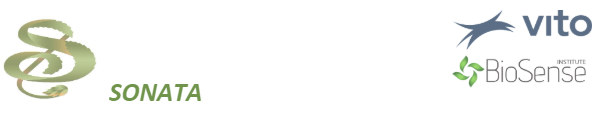
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

# offline habitat map generation using the openEO generated CatBoost models and feature data cubes
In this notebook we apply the generated CatBoost models on the openEO generated feature data cubes to run the hierarchical EUNIS habitat mapping. Output are habitat occurrence probability layers for each EUNIS habitat existing in the test sites.

IMPORTANT: this script is outdated. We now apply the ML models directly in openEO. In this way we do not have first to generate the feature datacubes in openEO, download them and apply the inference offline. THSI SCRIPT IS ONLY FOR TRAINING PURPOSES.

created by: Dr. Marcel Buchhorn

In [5]:
import os
import pandas as pd
import json
import rioxarray
from catboost import CatBoostClassifier
import numpy as np
import xarray as xr
from eo_processing.utils.storage import storage

#### declaration area
In this example we only use the Serbia model generated by the participants. Normally, we create bio-geographic zone specific ensemble models and store them in the `model storage`. From there we pull the correct hierarchical model on demand depending on the feature datacube zonal location and apply all single CatBoost models of the ensemble model in a loop.

In [6]:
# overwrite all search algorithms and select the training ones
path_catboost_model = os.path.normpath(r'./data/serbia_test_model_L1.cbm')
path_predictors_model = os.path.normpath(r'./data/serbia_test_model_L1_predictors.json')

model_list = [(path_catboost_model, path_predictors_model, 'Level1', 'class-0')]


# access to S3 SONATA storage
sonata_credentials = {
    's3_access_key': "37321ed00a1549bcaab75d0e437ae155",
    's3_secret_key': "2de9e97abcab413e89f45b6c3184893d",
    's3_endpoint': "https://s3.waw3-1.cloudferro.com",
    'bucket_name': "sonata-waw3-1-5q898zye7hp0yud0n8ot6nuzp7d8t3khy7faxzzvyj64avl81"
}
s3_prefix = 'feature-datacubes/v1/2024'  # the base folder on the SONATA S3 were all feature data cubes are saved

path_root_out = os.path.normpath(r'C:\Users\BUCHHORM\Downloads\inference_output')  # adapt
path_encoder = os.path.normpath(r'./data/LUT_topology_EUNIS2021plus_v1.csv')
temp_folder = os.path.join(path_root_out, 'temp')

os.makedirs(temp_folder, exist_ok=True)
os.makedirs(path_root_out, exist_ok=True)

### get overview of models and input cubes
First we create and overview of the datacubes on the S3 and filter them to the correct biogeographic zone

In [7]:
sonta_storage = storage(sonata_credentials)
s3_files = sonta_storage.get_file_keys(s3_directory=s3_prefix)
df_s3_files = pd.DataFrame(s3_files, columns=['file_key'])
# Extract the file name (basename) from the file_path
df_s3_files['basename'] = df_s3_files['file_key'].apply(lambda x: os.path.splitext(x.split('/')[-1])[0])
# split out info like biogeographic zone
df_s3_files = df_s3_files.join(
    df_s3_files['basename']
    .str.split('_', expand=True)
    .rename(columns={0: 'file_prefix', 1: 'version', 2: 'kind', 3: 'year', 4: 'tileID', 5: 'zone'})
)
df_s3_files['year'] = pd.to_datetime(df_s3_files['year'], format='year%Y')

In [8]:
df_s3_files.head()

,file_key,basename,file_prefix,version,kind,year,tileID,zone
0,feature-datacubes/v1/2024/Serbia_v1_feature-cu...,Serbia_v1_feature-cube_year2024_E498N252_CON,Serbia,v1,feature-cube,2024-01-01,E498N252,CON
1,feature-datacubes/v1/2024/Serbia_v1_feature-cu...,Serbia_v1_feature-cube_year2024_E498N254_CON,Serbia,v1,feature-cube,2024-01-01,E498N254,CON
2,feature-datacubes/v1/2024/Serbia_v1_feature-cu...,Serbia_v1_feature-cube_year2024_E498N254_PAN,Serbia,v1,feature-cube,2024-01-01,E498N254,PAN
3,feature-datacubes/v1/2024/Serbia_v1_feature-cu...,Serbia_v1_feature-cube_year2024_E498N256_CON,Serbia,v1,feature-cube,2024-01-01,E498N256,CON
4,feature-datacubes/v1/2024/Serbia_v1_feature-cu...,Serbia_v1_feature-cube_year2024_E498N256_PAN,Serbia,v1,feature-cube,2024-01-01,E498N256,PAN


In [9]:
# for the test we just chose a random feature datacube to apply the inference on
df_s3_files = df_s3_files.sample(n=1, random_state=1)

### set some functions for the processing

In [10]:
# habitat dict (encoder) -> raster value to habitat name
dhabitat = pd.read_csv(path_encoder, index_col=0).set_index('raster_value')['eunis_code'].to_dict()

In [11]:
# function to run the probability prediction
# NOTE: this processing is NOT USING block processing since we can still handle a 2000x2000 pixel cube with 253 bands in one go
def inference(data: xr.Dataset, path_catboost_model, path_predictors_model, blevel, bmodel, label_encoder: dict) -> xr.Dataset:
    """
    Performs inference on the provided dataset using a pre-trained CatBoost model. The function processes
    the input data, applies the CatBoost model to predict habitat probabilities, and outputs the results in
    an xarray.Dataset with appropriate attributes and data structures. The resulting dataset represents
    probability layers for habitat types with metadata and specified CRS.

    :param data: An xarray.Dataset containing the input features for habitat classification. The dataset
        is expected to have 'x' and 'y' coordinates and multiple data variables representing the predictors.
    :param path_catboost_model: Path to the CatBoost model file. The model should be pre-trained for habitat
        classification tasks and stored in a format compatible with the CatBoost library.
    :param path_predictors_model: Path to a JSON file containing predictor names required by the CatBoost model.
        The file specifies the feature names expected by the model for prediction.
    :param blevel: Habitat classification level information used to define the output dataset band names.
    :param bmodel: Habitat classification model information used to define the output dataset band names.
    :param label_encoder: A dictionary mapping habitat class labels to their corresponding names. Used for
        generating meaningful output layer names in the resulting dataset.
    :return: An xarray.Dataset containing habitat probabilities for each class predicted by the model. Each
        data variable in the dataset represents a habitat class probability layer with appropriate nodata
        values, CRS, and metadata.
    """
    # Load the CatBoost model from the specified path
    catboost_model = CatBoostClassifier()
    catboost_model.load_model(path_catboost_model)

    # extract the feature names needed from json file
    with open(path_predictors_model, 'r') as f:
        predictors_data = json.load(f)

    # set the predictor names as feature names in the catboost model
    catboost_model.set_feature_names(predictors_data)

    # Filter the data by the variable names specified in predictors_data
    filtered_data = data[catboost_model.feature_names_]

    # info of original array shape
    len_y = filtered_data.sizes['y']
    len_x = filtered_data.sizes['x']
    len_features = len(filtered_data.data_vars)
    # info for result bands (probability layer for the single habitat types of the model)
    len_habitats = catboost_model.classes_.shape[0]

    ##### here comes the real work
    # Predict the probabilities with the CatBoost model on the filtered data
    # the Xarray data is transferred to numpy array with shape [bands, y, x] and has to be reshaped to [y*x, bands] (known as [object_count, feature_count]])
    habitat_proba = catboost_model.predict_proba(filtered_data.to_array().values.reshape(len_features,len_y * len_x).T)

    # multiply with 100 to prepare for Byte format
    habitat_proba = habitat_proba * 100
    # now we have to reshape the habitat proba from [y*x, habitat_classes] to rasterio standard [bands, y, x]
    habitat_proba = habitat_proba.reshape(len_y, len_x, len_habitats).transpose(2, 0, 1).astype(np.uint8)

    ##### create the output xarray.Dataset
    # create the correct band names for the probability layers in the order of the catboost_model.classes_
    # EUNIS-level_model-name_habitat-name_habitat-raster-value
    # e.g. Level1_class-0_habitat-T-80000
    # e.g. Level2_class-T_habitat-T1-80100
    # e.g. Level3_class-T1_habitat-T11-80101
    bnames = [f'{blevel}_{bmodel}_habitat-{label_encoder[x]}-{x}' for x in catboost_model.classes_]

    # specify the nodata value
    nodata_val = 255

    # create the xarray.dataset
    habitat_proba_ds = xr.Dataset(
        {name: (['y', 'x'], habitat_proba[i]) for i, name in enumerate(bnames)},
        coords={
            'x': data.coords['x'],
            'y': data.coords['y']
        },
        attrs=data.attrs  # Copy over attributes from the original data
    )
    # set the crs
    habitat_proba_ds.rio.write_crs(data.rio.crs, inplace=True)
    # Set nodata value for each variable
    for var in habitat_proba_ds.data_vars:
        habitat_proba_ds[var].rio.write_nodata(nodata_val, inplace=True)
    # make sure all possible nan are replaced by new nodata value
    habitat_proba_ds = habitat_proba_ds.fillna(nodata_val)
    # del the openEO attribute
    del habitat_proba_ds.attrs['PROCESSING_SOFTWARE']

    # add some DataArray attributes
    for var in habitat_proba_ds.data_vars:
        habitat_proba_ds[var].encoding['habitat_class'] = var.split('_')[2].split('-')[1]
        habitat_proba_ds[var].encoding['class_raster_value'] = var.split('_')[2].split('-')[2]

    return habitat_proba_ds

## loop over all data cubes of the test sides and the models

In [12]:
#loop over all data cubes
for cube in df_s3_files.itertuples():
    print(f'* run inference on cube: {cube.basename}')

    # download the datacube from s3 to temp folder
    print(f'  * download cube from s3')
    local_file_path = os.path.join(os.path.normpath(temp_folder), os.path.basename(cube.file_key))
    if not os.path.exists(local_file_path):
        cube_path = sonta_storage.download_file_key(s3_object_key=cube.file_key, temp_folder=temp_folder)
    else:
        cube_path = local_file_path

    # Load the test_path into a xarray DataArray with bands as variables
    data = rioxarray.open_rasterio(cube_path, band_as_variable=True, masked=True)
    # adapt the band name to the feature names extracted from the metadata
    data = data.rename({band:data[band].attrs["long_name"] for band in data})

    # ToDo: here a temporal fix since openEO file have no conform EPSG code for 3035
    data.rio.write_crs(3035, inplace=True)
    
    # init the list holding the Xarray Datasets for the final merge in the end
    lDatasets = []

    # loop over all models we have to run
    for model in model_list:
        print(f'  * run inference with model: {model[0]}')
        # run the prediction and xarray Dataset generation for the model and add to results
        lDatasets.append(inference(data, model[0], model[1], model[2], model[3], dhabitat))

    # merge all model Datasets into one big
    result = xr.merge(lDatasets)

    # set the CRS
    result.rio.write_crs(data.rio.crs, inplace=True)
    
    # output file name
    out_file_name = os.path.join(path_root_out, cube.basename.replace('feature-cube', 'habitat_probabilities'))

    # Save habitat_proba_ds as a Cloud Optimized GeoTIFF (COG)
    result.rio.to_raster(out_file_name, driver='COG')

    # free memory
    del data
    del lDatasets
    del result

* run inference on cube: Serbia_v1_feature-cube_year2024_E516N246_CON
  * download cube from s3
  * run inference with model: data\serbia_test_model_L1.cbm
